# Case Study 2 : Data Science in Financial Data

**Recommended Readings:** 
* [Quantopian Tutorials](https://www.quantopian.com/tutorials/) 
* Please register an account in [Quantopian online notebook system](https://www.quantopian.com/notebooks/).
* Upload this file into the system and start working on your idea.


**NOTE**
* Please download your code (notebook file as an ipynb file) and include it in your submission.


# Problem: pick a data science problem that you plan to solve using Stock Price Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data available and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

Our aim is to find the correlation between a wide variety of variables like 'traders mood on twitter','news journals prediction', etc and the stock price on a daily basis. Then, we try to predict the stock price using linear regression and ARIMA. Finally, we see whether when a stock price increases in a particular sector, does it affect any other sector significantly? If so, when would the ideal time to migrate your stocks to another sector?
This will help us understand the nature of various variables that govern the stock market and make a decision with more logic than before. Since, the introduction of stock market, it was and is a challenge to predict the stock prices ,so that individuals can become richer and accumalate wealth.

# Data Collection/Processing: 

In [18]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import aggregated_twitter_withretweets_stocktwits as trader_sentiment
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import StaticAssets
from quantopian.pipeline.data.sentdex import sentiment
from quantopian.pipeline.data import EquityPricing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Data Exploration: Exploring the Dataset

**plot the weekly returns of a set of stocks of your choice** 


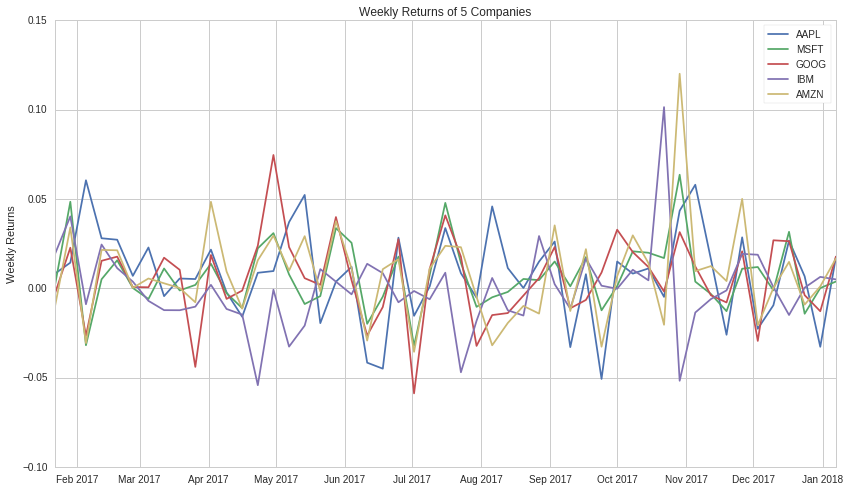

In [19]:
# get companies
cmpn = ['AAPL','MSFT','GOOG','IBM','AMZN']
# create iteration for 5 companies that we choose 
for i in cmpn:
    ori = get_pricing(i, start_date='2017-01-09', end_date='2018-01-02', frequency='daily', 
                 fields=['open_price', 'close_price'])
#     print(ori.head(5))
    
# choose close price to calculate weekly returns
    cp = get_pricing(i, start_date='2017-01-09', end_date='2018-01-02', frequency='daily', 
                 fields='close_price').dropna()
#     print(cp.head(3))
    
# use resample funtion to calculate weekly returns 
    wr = cp.resample('W').ffill().pct_change()
#     print(wr.head(10))
    
# plot these 5 companies weekly returns in line graph
    plt.plot(wr)
    plt.ylabel('Weekly Returns')
    plt.legend(['AAPL','MSFT','GOOG','IBM','AMZN'])
    plt.title('Weekly Returns of 5 Companies');
    

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

We are going to check the correlation between variables using the pipeline package offered in quantopian by creating a dataframe from the pipeline and then using the in-built function for correlation from numpy package. 
Then, we created a dummy variable having values (0,1), where 0 implies an increase and 1 implies a decrease in daily stock. After that, we again calculated the correlation to see if it makes any difference.
Second, we implemented linear regression and ARIMA data models on the Apple.inc company.
Finally, we plotted the stock prices from different sectors and visually looked for intersections in the plots,
since that would be the ideal point of time to reallocate your stocks based on sectors(if such points existed).








Write codes to implement the solution in python:

In [20]:
#---------------------------Correlation------------------------------------
s = sentiment.sentiment_signal.latest
price= trader_sentiment.bull_bear_msg_ratio.latest
cp = EquityPricing.close.latest
aapl = symbols('AAPL')
ibm = symbols('IBM')
gool = symbols('GOOG')
ms = symbols('MSFT')
amz = symbols('AMZN')
fb = symbols('FB')
tl = symbols('TSLA')
ub = symbols('UBER')

aapl_ibm = StaticAssets([aapl,ibm,gool,ms,amz,fb,tl,ub])
pipe = Pipeline(
    screen = aapl_ibm,
    columns = {
        'trader': price,
        'news': s,
        'closing': cp,
        }
    )
df = run_pipeline(pipe, '1-9-2017', '1-2-2018')
print(df.head())
print(np.corrcoef(df.trader,df.news))
print(np.corrcoef(df.trader,df.closing))
print(np.corrcoef(df.closing,df.news))

                                                closing  news  trader
2017-01-09 00:00:00+00:00 Equity(24 [AAPL])      117.91   5.0  4.2750
                          Equity(3766 [IBM])     169.57   2.0  7.5000
                          Equity(5061 [MSFT])     62.84   3.0  6.8333
                          Equity(16841 [AMZN])   795.99  -1.0  3.7500
                          Equity(39840 [TSLA])   229.01  -3.0  2.5250
[[ 1.         -0.02610738]
 [-0.02610738  1.        ]]
[[ 1.         -0.03930673]
 [-0.03930673  1.        ]]
[[ 1.          0.13313941]
 [ 0.13313941  1.        ]]


In [21]:
pip = Pipeline(
    screen = StaticAssets([aapl,ibm,gool,ms,amz,fb,tl,ub]),
    columns = {
        'cp':EquityPricing.close.latest,
        'op':EquityPricing.open.latest,
        'price': price,
        'high':EquityPricing.high.latest,
        'low':EquityPricing.low.latest,
        'vol':EquityPricing.volume.latest,
    }
)
ld = run_pipeline(pip, '1-9-2017', '1-2-2018')
ld1=np.copy(ld)
x = ld1[:,3:4] # get closing price

In [22]:
# Creating dummy varible up_down to check if it makes a difference
a = [0] # starting price has no previous day
for i in range(len(x)-1):
    a.append(x[i+1]-x[i])


w = [] #Convert to 0 & 1
for i in range(len(a)):
    if a[i]>=0:
        w.append(int(1))
    else:
        w.append(int(0))

  

In [23]:
import quantopian.pipeline.data.factset.estimates as fe # Broker recommendations dataset
fe_rec = fe.ConsensusRecommendations
pip3 = Pipeline(
    screen = StaticAssets([aapl,ibm,gool,ms,amz,fb,tl,ub]),
    columns = {
        'rec_buy': fe_rec.buy.latest,
        'rec_hold': fe_rec.hold.latest,
        'rec_sell': fe_rec.sell.latest,
        'rec_mark': fe_rec.mark.latest,
    }
)
az = run_pipeline(pip3, '1-9-2017', '1-2-2018')


In [24]:
az1 = np.copy(az)

f_d = az1[:,0:4]
final_cols = pd.DataFrame(f_d)
up_down = pd.DataFrame(w)
news_sentiment = pd.DataFrame(np.copy(df.news))
bbr = pd.DataFrame(np.copy(df.trader))
#type(f_d)

#type(final_cols)
frames = [final_cols, news_sentiment, bbr, up_down]
result = pd.concat(frames,axis=1)
result.columns = ['buy','hold','mark','sell','news_sentiment','bbr','up_down']
print(result)
print(np.corrcoef(result.buy,result.up_down))
print(np.corrcoef(result.bbr,result.up_down))
print(np.corrcoef(result.news_sentiment,result.up_down))
#result.isnull()


       buy  hold      mark  sell  news_sentiment     bbr  up_down
0     30.0   7.0  1.311111   2.0             5.0  4.2750        1
1      6.0  15.0  1.860000   3.0             2.0  7.5000        1
2     22.0   9.0  1.400000   2.0             3.0  6.8333        0
3     32.0   4.0  1.166667   0.0            -1.0  3.7500        1
4      4.0  10.0  2.023810   4.0            -3.0  2.5250        0
5     36.0   3.0  1.159091   1.0             6.0  1.5849        0
6     37.0   2.0  1.127907   1.0             2.0  4.8889        1
7     30.0   7.0  1.311111   2.0             2.0  2.8123        0
8      6.0  15.0  1.860000   3.0             2.0  2.0833        1
9     22.0   9.0  1.400000   2.0             2.0  2.5500        0
10    32.0   4.0  1.166667   0.0            -3.0  2.8778        1
11     4.0  10.0  2.023810   4.0            -3.0  1.4301        0
12    37.0   3.0  1.155556   1.0             1.0  2.2667        0
13    37.0   2.0  1.127907   1.0             2.0  3.9259        1
14    30.0

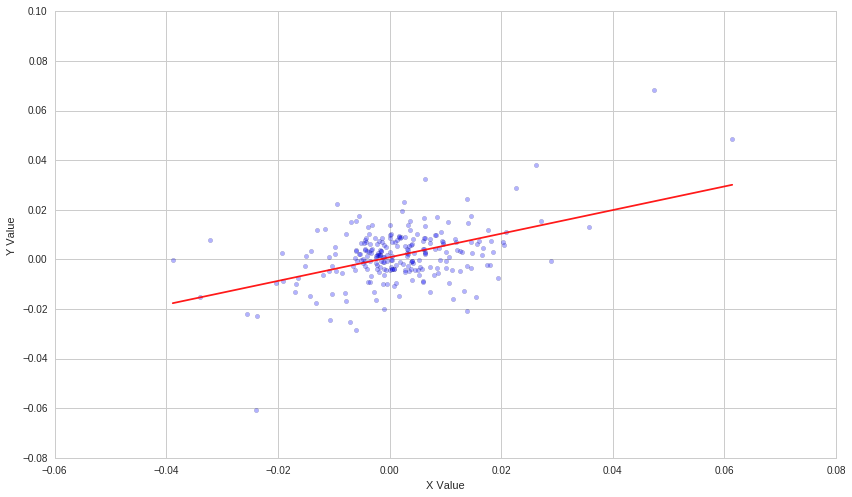

In [25]:

# --------------Linear Regression------------------------------------
#linear regression of open_price and close_price

#import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

def lr(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X1 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X1 * b + a
    # Plot the raw data
    plt.scatter(X, Y, alpha=0.3) 
    # Add the regression line, colored in red
    plt.plot(X1, Y_hat, 'r', alpha=0.9);  
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

# get open price data 
start = '2017-01-09'
end = '2018-01-02'
pre = get_pricing('AAPL', fields='open_price', start_date=start, end_date=end)
res = get_pricing('AAPL', fields='close_price', start_date=start, end_date=end)

# take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = pre.pct_change()[1:]
r_b = res.pct_change()[1:]

lr(r_b.values, r_a.values)



In [26]:
#----------------------------ARIMA---------------------------------
cp = EquityPricing.close.latest #Creating dataset for ARIMA
aapl_ibm = StaticAssets([aapl])
pipe = Pipeline(
    screen = aapl_ibm,
    columns = {
        'close': cp,

        }
    )
df = run_pipeline(pipe, '1-9-2017', '1-2-2018')

df = df.reset_index()
df.rename(columns={'level_0':'date'}, inplace=True) #Getting dates from the pipeline

from datetime import datetime

df['date'] = pd.to_datetime(df['date'], unit='ms').apply(lambda x: x.date())
df= df.drop(['level_1'],axis = 1)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  247
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -477.346
Method:                       css-mle   S.D. of innovations              1.671
Date:                Thu, 24 Oct 2019   AIC                            968.692
Time:                        20:18:39   BIC                            993.258
Sample:                    01-10-2017   HQIC                           978.583
                         - 01-02-2018                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.2022      0.123      1.639      0.102        -0.040     0.444
ar.L1.D.close     0.0292      0.063      0.461      0.645        -0.095     0.154
ar.L2.D.close    -0.0360      0.063     

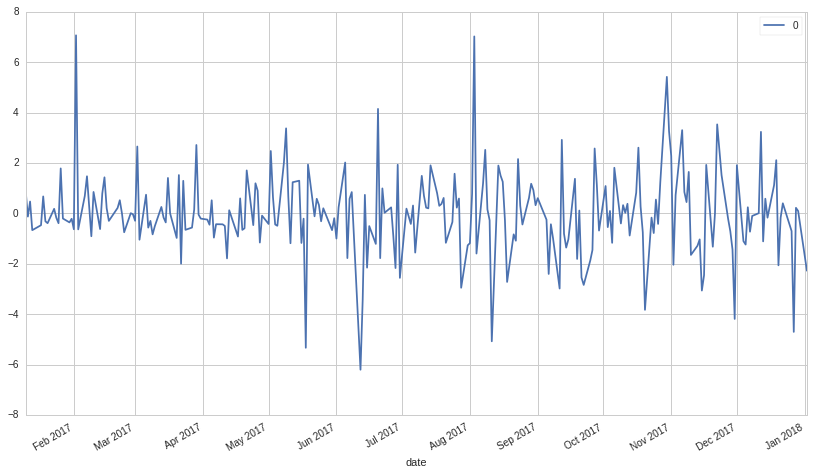

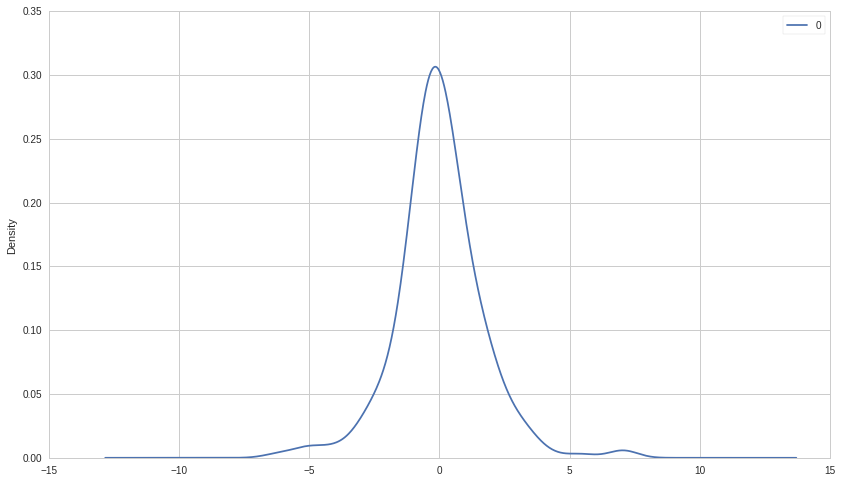

                0
count  247.000000
mean     0.000057
std      1.674425
min     -6.198804
25%     -0.789970
50%     -0.098599
75%      0.766888
max      7.069747


In [27]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import pandas as pd
import numpy as np

s = np.copy(df.date)

#type(df.date)
x= pd.DataFrame(df.close)
x.index = pd.to_datetime(df.date) #ARIMA takes a series with date as index as input


# fit model
model = ARIMA(x, order=(5,1,0)) # lag value is 5 , so that we can take weekly data for modeling 
model_fit = model.fit(disp=0)
print(model_fit.summary())
#plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

predicted=162.898920, expected=163.330000
predicted=163.252984, expected=163.970000
predicted=164.308658, expected=164.040000
predicted=164.687111, expected=162.080000
predicted=162.687016, expected=161.920000
predicted=162.410058, expected=161.270000
predicted=161.873042, expected=158.630000
predicted=158.811225, expected=161.490000
predicted=161.365526, expected=160.860000
predicted=161.149127, expected=159.620000
predicted=159.360578, expected=158.270000
predicted=158.507780, expected=159.880000
predicted=160.602029, expected=158.640000
predicted=158.726645, expected=158.720000
predicted=158.500620, expected=156.050000
predicted=156.505849, expected=153.400000
predicted=153.954027, expected=151.760000
predicted=152.035965, expected=150.560000
predicted=150.607304, expected=153.220000
predicted=152.672639, expected=154.200000
predicted=153.752871, expected=153.260000
predicted=152.798930, expected=154.030000
predicted=154.196677, expected=153.810000
predicted=154.580253, expected=154

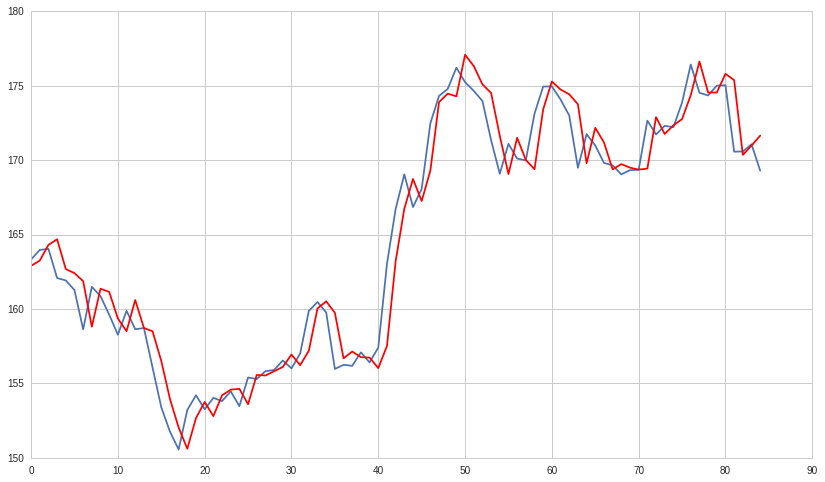

In [28]:
# testing ARIMA

from sklearn.metrics import mean_squared_error
X = x.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
c =pyplot.show()

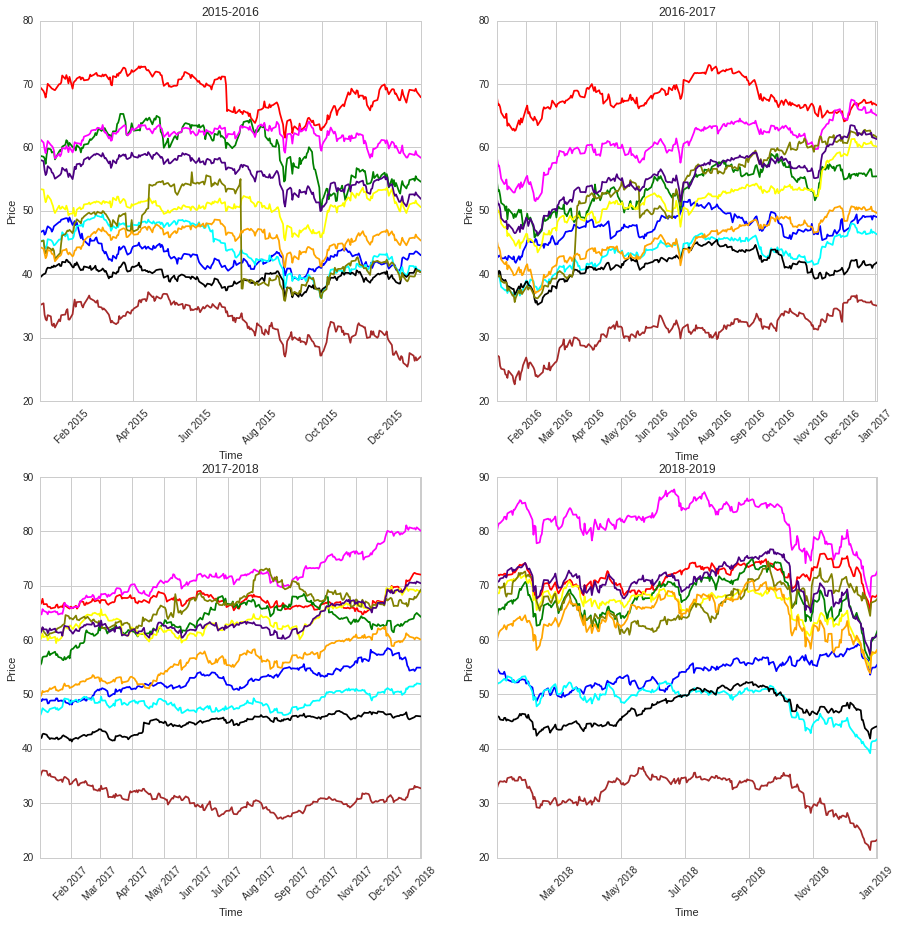

In [35]:
#---------------------------Sector-wise Comparision-----------------------------------

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data import Fundamentals
import matplotlib.pyplot as plt

def tech_sector_pipeline(sector):
    #UNIVERSE
    tradable_stocks = QTradableStocksUS()
    sectors = morningstar.asset_classification.morningstar_sector_code.latest
    
    tech_sector = sectors.eq(sector)
    price_filter = USEquityPricing.close.latest > 0
    
    my_universe = tradable_stocks & tech_sector & price_filter
    
    #Data Columns
    prices = USEquityPricing.close.latest
    market_cap = Fundamentals.market_cap.latest
    
    # Return Pipeline
    return Pipeline(columns={
        'price':prices,
        'market_cap':market_cap
    },screen=my_universe)

# Different sectors
sector_mappings = {  
   101.0: "Basic Materials",  
   102.0: "Consumer Cyclical",  
   103.0: "Financial Services",  
   104.0: "Real Estate",  
   205.0: "Consumer Defensive",  
   206.0: "Healthcare",  
   207.0: "Utilites",  
   308.0: "Communication Services",  
   309.0: "Energy",  
   310.0: "Industrials",  
   311.0: "Technology" 
   
}  

fig, axs = plt.subplots(2, 2,figsize=(15,15))
a = np.array([2015,2016,2017,2018,2019])
k=0
for i in range(2):
    for j in range(2):
  
        #d = 'bgrcymkbgrcymk'
        d=['red','green','blue','cyan','magenta','yellow','black','olive','brown','indigo','orange']
        g=0

        for items in sector_mappings.items():
        
            stocks = run_pipeline(tech_sector_pipeline(items[0]),str(a[k])+'-01-01',str(a[k+1])+'-01-01')
            axs[i, j].plot(stocks.price.groupby(level=0).mean(),str(d[g]))
            g+=1
        
        axs[i, j].set_title(str(a[k])+'-'+str(a[k+1]))

        k+=1

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Price')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.show()


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.



Correlation between traders mood and stock price is -0.02610738.
Correlation between news journalists mood and stock price is -0.03930673.
Correlation between news journalists mood and traders mood is 0.13313941.

All of these imply a very weak relationship.

After creating dummy variable 'up_down', we added another dataset 'Broker recommendations',
Correlation between traders mood and stock price is 0.05356768.
Correlation between news journalists mood and stock price is 0.08183384.
Correlation between brokers's recommendation and stock price is 0.30817204.

Looks like brokers are more reliable than newspapers and other traders.

Linear regression gave us an accuracy of 22% which indicates that it is a bad model for predicting stock prices.

ARIMA is a much better model yeilding an mean squared error of 3.472



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     67.38
Date:                Thu, 24 Oct 2019   Prob (F-statistic):           1.28e-14
Time:                        20:30:46   Log-Likelihood:                 782.75
No. Observations:                 247   AIC:                            -1561.
Df Residuals:                     245   BIC:                            -1554.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0008      0.001      1.281      0.201        -0.000     0.002
x1             0.4761      0.058      8.209      0.000         0.362     0.590
==============================================================================
Omnibus:                       26.666   Durbin-Watson:                   2.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.770
Skew:                          -0.144   Prob(JB):                     8.06e-28
Kurtosis:                       6.470   Cond. No.                         89.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

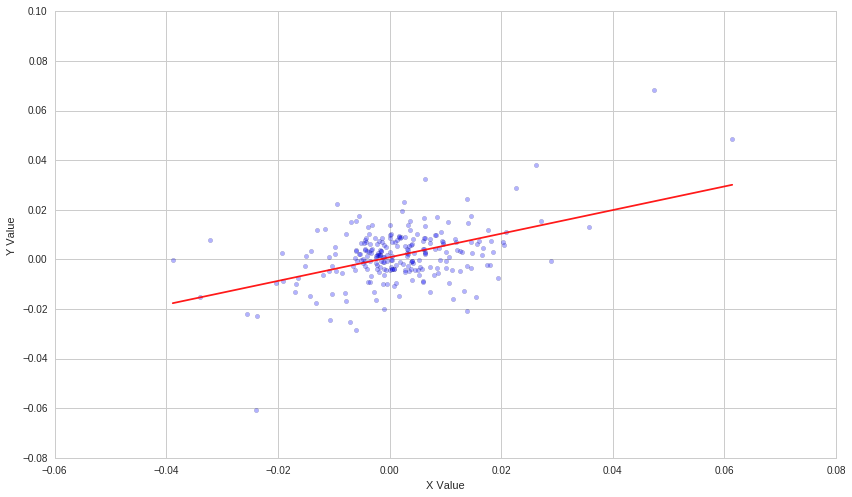

In [33]:
#Visuals
#Correlation coefficients printed in the main code
#linear regression
lr(r_b.values, r_a.values)


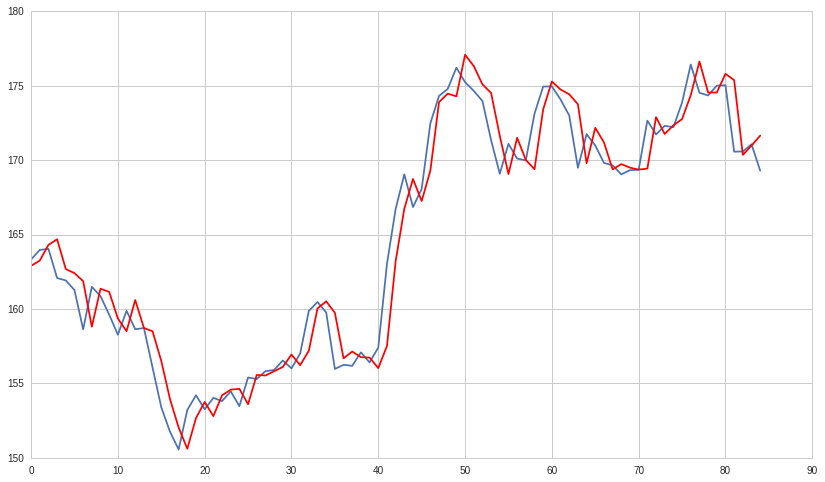

In [34]:
#ARIMA Predicted(red) vs expected(blue)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
c =pyplot.show()

#refer code for plots of sector-wise stocks
#The points of intersection would be ideal to change your sector 


# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


**How to submit:**

        Please submit through Canvas, in the Assignment "Case Study 2".
        
**Note: Each team only needs to submit one submission in Canvas**